In [28]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [30]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [31]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [32]:
tf.keras.backend.clear_session()

In [33]:
subject = 'Maranhão - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [34]:
data = pd.read_csv('2003_mo_model_input_MA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Maranhão - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Maranhão - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Maranhão - IDH Longevidade
0,2003-1,23.368400,1.609842e+06,0.614766,0.542831,8.213662,43.342,2.330394,1005.666766,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,0.635570,4.315322e+07,2.636001e+06,6.034057,3.872495e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.722204
1,2003-2,23.167977,1.619288e+06,0.615338,0.543362,8.207986,28.663,2.330957,1005.664945,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,0.635997,4.320832e+07,2.636851e+06,6.036083,3.874405e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.722513
2,2003-3,23.563273,1.628734e+06,0.615910,0.543892,8.202310,27.900,2.331285,1005.663882,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,0.636424,4.326343e+07,2.637701e+06,6.038110,3.876316e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.722821
3,2003-4,24.008345,1.638180e+06,0.616483,0.544422,8.196633,25.739,2.331321,1005.663768,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,0.636851,4.331853e+07,2.638551e+06,6.040136,3.878226e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.723129
4,2003-5,24.366896,1.647626e+06,0.617055,0.544953,8.190957,30.203,2.397956,1005.413091,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,0.637278,4.337364e+07,2.639401e+06,6.042163,3.880136e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.723438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34913.291508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34868.689412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34805.943727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34730.731162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


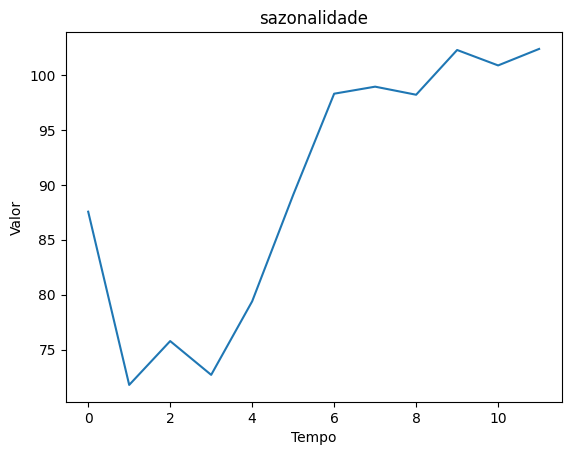

,sazonalidade
sazonalidade,
0,87.556270
1,71.779152
2,75.772632
3,72.694577
4,79.392843
5,89.079325
6,98.301964
7,98.942987
8,98.207642


In [35]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [36]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Maranhão - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Maranhão - IDH Longevidade,sazonalidade,Maranhão - Consumo de Cimento (t)
0,2003-1,23.368400,1.609842e+06,0.614766,0.542831,8.213662,2.330394,1005.666766,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,0.635570,4.315322e+07,2.636001e+06,6.034057,3.872495e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.722204,87.556270,43.342
1,2003-2,23.167977,1.619288e+06,0.615338,0.543362,8.207986,2.330957,1005.664945,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,0.635997,4.320832e+07,2.636851e+06,6.036083,3.874405e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.722513,71.779152,28.663
2,2003-3,23.563273,1.628734e+06,0.615910,0.543892,8.202310,2.331285,1005.663882,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,0.636424,4.326343e+07,2.637701e+06,6.038110,3.876316e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.722821,75.772632,27.900
3,2003-4,24.008345,1.638180e+06,0.616483,0.544422,8.196633,2.331321,1005.663768,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,0.636851,4.331853e+07,2.638551e+06,6.040136,3.878226e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.723129,72.694577,25.739
4,2003-5,24.366896,1.647626e+06,0.617055,0.544953,8.190957,2.397956,1005.413091,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,0.637278,4.337364e+07,2.639401e+06,6.042163,3.880136e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.723438,79.392843,30.203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34913.291508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.392843,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34868.689412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.079325,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34805.943727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.301964,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34730.731162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.942987,NaN


In [37]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      56.124
1      39.810
2      44.937
3      41.661
4      47.350
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Maranhão - Consumo de Cimento (t), Length: 249, dtype: float64

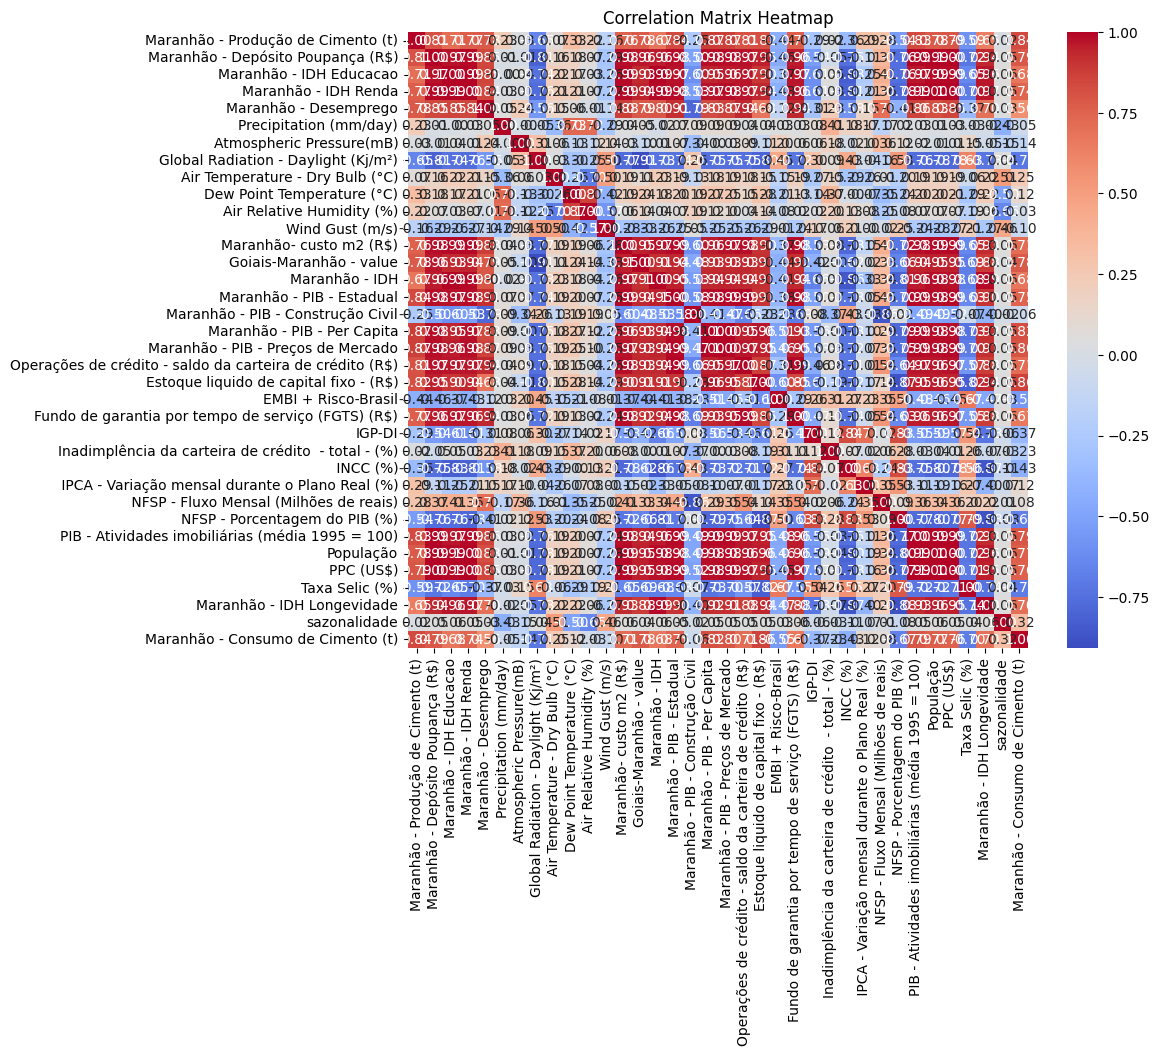

In [38]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [40]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Maranhão - Produção de Cimento (t),2.336409e+03
1,Maranhão - Depósito Poupança (R$),2.011689e+04
2,Maranhão - IDH Educacao,1.220733e+07
3,Maranhão - IDH Renda,2.926473e+08
4,Maranhão - Desemprego,2.391513e+03
5,Precipitation (mm/day),5.371853e+00
6,Atmospheric Pressure(mB),4.248329e+00
7,Global Radiation - Daylight (Kj/m²),8.009131e+01
8,Air Temperature - Dry Bulb (°C),1.257825e+02
9,Dew Point Temperature (°C),2.678845e+02


In [41]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,23.368400,1.609842e+06,0.614766,0.542831,8.213662,2.330394,1005.666766,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,4.315322e+07,2.636001e+06,6.034057,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,87.556270
1,23.167977,1.619288e+06,0.615338,0.543362,8.207986,2.330957,1005.664945,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,4.320832e+07,2.636851e+06,6.036083,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,71.779152
2,23.563273,1.628734e+06,0.615910,0.543892,8.202310,2.331285,1005.663882,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,4.326343e+07,2.637701e+06,6.038110,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,75.772632
3,24.008345,1.638180e+06,0.616483,0.544422,8.196633,2.331321,1005.663768,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,4.331853e+07,2.638551e+06,6.040136,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,72.694577
4,24.366896,1.647626e+06,0.617055,0.544953,8.190957,2.397956,1005.413091,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,4.337364e+07,2.639401e+06,6.042163,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,79.392843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,35.722671,5.166547e+06,0.690187,0.606576,12.377711,1.523474,1005.947945,1347.362886,27.694927,22.812100,75.801099,2.207460,24025.676940,0.374870,5.216675e+07,2.561849e+06,6.220634,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,416.859692,0.583985,98.942987
176,34.933872,5.183879e+06,0.690231,0.606516,12.365936,1.768383,1005.519812,1371.253964,27.688025,22.731415,75.428304,2.336319,24120.690938,0.375507,5.216034e+07,2.562159e+06,6.220486,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,417.748887,0.753312,98.207642
177,34.493738,5.201211e+06,0.690276,0.606455,12.354161,1.976617,1005.098812,1345.546381,27.508207,22.776365,76.373414,2.321574,24214.022001,0.376148,5.215393e+07,2.562469e+06,6.220339,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,418.601189,0.882343,102.283057
178,33.966493,5.218543e+06,0.690320,0.606395,12.342386,2.120898,1004.935052,1306.492418,27.196587,22.862284,78.198148,2.098625,24309.891289,0.376801,5.214751e+07,2.562779e+06,6.220192,3.083099e+06,7.776397e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,419.430070,1.004174

In [42]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,-1.708789,-1.883857,-1.958386,-0.755929,-0.198498,0.315215,-0.021090,0.049383,-0.716252,-0.581553,0.649182,-1.633977,-0.886364,-1.626226,-0.407800,-2.046544,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-0.192442
1,-1.700730,-1.857296,-1.930563,-0.758809,-0.197521,0.313030,-0.021090,0.049246,-0.711784,-0.578061,0.646138,-1.609695,-0.907289,-1.608286,-0.389752,-2.013333,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.562492
2,-1.692672,-1.830736,-1.902740,-0.761688,-0.196951,0.311756,-0.021090,0.049166,-0.709178,-0.576023,0.644362,-1.587776,-0.937020,-1.590346,-0.371704,-1.980122,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-1.215707
3,-1.684613,-1.804175,-1.874917,-0.764567,-0.196890,0.311620,-0.021090,0.049158,-0.708899,-0.575805,0.644172,-1.567463,-0.963285,-1.572407,-0.353656,-1.946912,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-1.482999
4,-1.676555,-1.777614,-1.847094,-0.767447,-0.081308,0.011059,0.080927,-0.313974,-0.571779,-0.286182,0.505517,-1.548141,-0.996868,-1.554467,-0.335607,-1.913701,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,-0.901336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.325442,1.616913,1.385413,1.356270,-1.598136,0.652347,-0.673981,1.787219,-0.877566,-1.506476,0.283229,1.679514,1.231466,1.308185,-1.982129,1.011132,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.421090,-1.472938,0.796355
176,1.340228,1.618979,1.382234,1.350297,-1.173331,0.139016,-0.670459,1.770071,-1.010100,-1.606156,0.529157,1.702873,1.243232,1.306097,-1.975548,1.008718,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.432650,-0.879688,0.732500
177,1.355014,1.621044,1.379055,1.344324,-0.812139,-0.365762,-0.674249,1.323349,-0.936265,-1.353447,0.501016,1.725819,1.255063,1.304009,-1.968968,1.006304,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.443731,-0.427616,1.086400
178,1.369800,1.623110,1.375876,1.338352,-0.561878,-0.562109,-0.680006,0.549187,-0.795133,-0.865540,0.075518,1.749389,1.267112,1.301921,-1.962388,1.003890,1.365401,0.562902,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.454507,-0.000772,0.964347


In [43]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,-1.708789,-1.883857,-1.958386,-0.755929,-0.198498,0.315215,-0.021090,0.049383,-0.716252,-0.581553,0.649182,-1.633977,-0.886364,-1.626226,-0.407800,-2.046544,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-0.192442
1,-1.700730,-1.857296,-1.930563,-0.758809,-0.197521,0.313030,-0.021090,0.049246,-0.711784,-0.578061,0.646138,-1.609695,-0.907289,-1.608286,-0.389752,-2.013333,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.562492
2,-1.692672,-1.830736,-1.902740,-0.761688,-0.196951,0.311756,-0.021090,0.049166,-0.709178,-0.576023,0.644362,-1.587776,-0.937020,-1.590346,-0.371704,-1.980122,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-1.215707
3,-1.684613,-1.804175,-1.874917,-0.764567,-0.196890,0.311620,-0.021090,0.049158,-0.708899,-0.575805,0.644172,-1.567463,-0.963285,-1.572407,-0.353656,-1.946912,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-1.482999
4,-1.676555,-1.777614,-1.847094,-0.767447,-0.081308,0.011059,0.080927,-0.313974,-0.571779,-0.286182,0.505517,-1.548141,-0.996868,-1.554467,-0.335607,-1.913701,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,-0.901336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.140900,1.575253,1.418592,1.461955,0.191501,0.816815,-0.661029,1.148370,-0.600124,-1.014275,0.406351,1.396849,1.097275,1.308038,-1.936001,1.022738,1.407354,0.759879,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.261902,0.499090,0.796355
164,1.157108,1.580693,1.416407,1.449180,-0.668553,0.209069,-0.660638,1.526312,-0.677306,-1.258373,0.659709,1.418686,1.105888,1.310991,-1.954439,1.023796,1.402136,0.749001,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.276272,0.323875,0.732500
165,1.173316,1.586132,1.414221,1.436404,-0.087806,-0.341171,-0.666892,1.518158,-0.472851,-1.093461,0.598618,1.442035,1.114449,1.313944,-1.972877,1.024855,1.398719,0.738124,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.290351,0.198030,1.086400
166,1.189524,1.591572,1.412036,1.423629,0.152159,-0.540742,-0.681143,0.946697,-0.192531,-0.595202,0.270447,1.466360,1.122956,1.316897,-1.991315,1.025913,1.393142,0.727246,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.304501,0.502803,0.964347


In [44]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      56.124
1      39.810
2      44.937
3      41.661
4      47.350
        ...  
163    73.445
164    69.471
165    83.004
166    77.332
167    58.591
Name: Maranhão - Consumo de Cimento (t), Length: 168, dtype: float64

In [45]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [46]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 30)

In [47]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
132,1.090022,0.628174,0.777610,1.157840,-0.853347,-0.573725,-0.687610,-0.917361,-0.520633,0.062047,-0.453764,0.763991,0.850601,1.032965,-0.081026,1.117548,0.992500,0.965586,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.878252,-0.590376,-0.192442
133,1.091161,0.637807,0.773235,1.180790,0.045175,-0.515850,-0.695037,-1.329056,-0.112227,0.589057,-0.917161,0.778792,0.854655,1.044554,-0.166961,1.105754,1.013803,0.962419,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.887574,-0.476859,-1.562492
134,1.092300,0.647441,0.768859,1.203739,0.449544,-0.112037,-0.694836,-1.367585,0.131573,0.797856,-1.144873,0.795393,0.858521,1.056144,-0.252896,1.093960,1.036490,0.959252,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.896990,-0.089952,-1.215707
135,1.093439,0.657074,0.764484,1.226689,0.610862,0.523354,-0.693012,-1.425795,0.120216,0.825884,-1.274045,0.810643,0.866037,1.067733,-0.338831,1.082166,1.059637,0.956085,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.906245,-0.814200,-1.482999
136,1.094578,0.666707,0.760109,1.249638,0.406682,0.990425,-0.688111,-1.250821,-0.096924,0.577102,-1.115646,0.826893,0.873515,1.079323,-0.424766,1.070372,1.080606,0.952918,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.915208,-0.917944,-0.901336
137,1.095718,0.676340,0.755734,1.272588,-0.837626,1.370129,-0.677813,-0.734543,-0.465957,0.023684,-0.618668,0.843374,0.881758,1.090912,-0.510701,1.058578,1.101264,0.949751,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.924126,-0.708692,-0.060183
138,1.096857,0.685973,0.751359,1.295538,-1.465518,1.364050,-0.668194,-0.617386,-0.830298,-0.341978,-0.209249,0.862294,0.896585,1.102502,-0.596635,1.046785,1.123860,0.946584,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.932114,-0.496126,0.740690
139,1.097996,0.695606,0.746984,1.318487,-1.528636,0.819550,-0.661725,-0.278819,-1.112785,-0.743792,0.225077,0.881210,0.907739,1.114091,-0.682570,1.034991,1.150086,0.943417,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.939863,-0.251065,0.796355
140,1.099135,0.705239,0.742609,1.341437,-0.951998,0.393850,-0.658449,0.148492,-1.296639,-1.104305,0.552124,0.900545,0.918912,1.125681,-0.768505,1.023197,1.179474,0.940250,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.947944,-0.593206,0.732500
141,1.100274,0.714873,0.738233,1.364386,-0.391657,0.131230,-0.659508,0.327411,-1.389991,-1.266888,0.613455,0.919526,0.930119,1.137270,-0.854440,1.011403,1.214576,0.937082,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.956229,-0.100794,1.086400


In [48]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 30)

In [49]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [50]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(72, activation='tanh',
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [51]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [52]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [53]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [54]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[763006643, 1483981621, 1742359552, 609790219, 4138265559, 700784822, 740711804, 2165444650, 2684049990, 1081045082]


Step: 0 ___________________________________________
val_loss: 153.7420654296875
winner_seed: 763006643


Step: 1 ___________________________________________
val_loss: 92.47537231445312
winner_seed: 1483981621


Step: 2 ___________________________________________
val_loss: 57.010643005371094
winner_seed: 1742359552


Step: 3 ___________________________________________
val_loss: 246.3090362548828


Step: 4 ___________________________________________
val_loss: 55.690895080566406
winner_seed: 4138265559


Step: 5 ___________________________________________
val_loss: 50.37871551513672
winner_seed: 700784822


Step: 6 ___________________________________________
val_loss: 68.46924591064453


Step: 7 ___________________________________________
val_loss: 51.932334899902344


Step: 8 ___________________________________________
val_loss: 71.6353988647461


Step: 9 _______________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,54.095787,51.857277,67.100609,77.449738,85.282806,89.103355,89.606331,93.372711,93.700714,90.016815,82.297729,74.245895
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,16.564217,1.061275,19.266609,32.122738,31.250805,28.446354,22.356331,22.599709,26.690712,8.888817,0.56073,2.595108


[1932544834, 3160802685, 146210762, 2969751277, 1286718873, 3108756395, 3455343783, 1628102659, 1161091676, 2723723828]


Step: 0 ___________________________________________
val_loss: 152.6029510498047
winner_seed: 1932544834


Step: 1 ___________________________________________
val_loss: 263.7093505859375


Step: 2 ___________________________________________
val_loss: 241.51296997070312


Step: 3 ___________________________________________
val_loss: 50.126014709472656
winner_seed: 2969751277


Step: 4 ___________________________________________
val_loss: 235.3004913330078


Step: 5 ___________________________________________
val_loss: 80.21009063720703


Step: 6 ___________________________________________
val_loss: 135.98995971679688


Step: 7 ___________________________________________
val_loss: 281.8977355957031


Step: 8 ___________________________________________
val_loss: 51.064842224121094


Step: 9 ___________________________________________
val_loss: 479.7801818847656
1/1 [===

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,50.860477,49.853069,51.147346,58.251198,64.38961,67.564117,74.21843,85.345642,93.952629,99.165283,97.118423,85.012711
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,19.799526,0.942932,3.313347,12.924198,10.357609,6.907116,6.96843,14.572639,26.942627,18.037285,15.381424,8.171707


[725934107, 2746602800, 3256861882, 1136575317, 2880832385, 2601730342, 2328672138, 926826775, 1551983578, 2654885816]


Step: 0 ___________________________________________
val_loss: 271.72027587890625
winner_seed: 725934107


Step: 1 ___________________________________________
val_loss: 49.07147216796875
winner_seed: 2746602800


Step: 2 ___________________________________________
val_loss: 59.37059783935547


Step: 3 ___________________________________________
val_loss: 71.68585968017578


Step: 4 ___________________________________________
val_loss: 276.8980712890625


Step: 5 ___________________________________________
val_loss: 240.72360229492188


Step: 6 ___________________________________________
val_loss: 35.69157028198242
winner_seed: 2328672138


Step: 7 ___________________________________________
val_loss: 247.53695678710938


Step: 8 ___________________________________________
val_loss: 42.37837219238281


Step: 9 ___________________________________________
val_loss: 48.92

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,52.025177,49.551243,51.232964,53.575928,59.112194,65.287758,68.707283,73.951668,76.208984,77.893555,78.217987,72.972115
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,18.634827,1.244759,3.398964,8.248928,5.080193,4.630756,1.457283,3.178665,9.198982,3.234444,3.519012,3.868889


[3283673596, 1160931888, 2242833866, 632778256, 244534879, 1260836414, 3800776628, 1613155761, 3740379129, 3593102866]


Step: 0 ___________________________________________
val_loss: 67.33364868164062
winner_seed: 3283673596


Step: 1 ___________________________________________
val_loss: 54.848045349121094
winner_seed: 1160931888


Step: 2 ___________________________________________
val_loss: 305.8712158203125


Step: 3 ___________________________________________
val_loss: 102.20420837402344


Step: 4 ___________________________________________
val_loss: 68.7776870727539


Step: 5 ___________________________________________
val_loss: 48.683250427246094
winner_seed: 1260836414


Step: 6 ___________________________________________
val_loss: 156.1026611328125


Step: 7 ___________________________________________
val_loss: 43.900794982910156
winner_seed: 1613155761


Step: 8 ___________________________________________
val_loss: 44.25925827026367


Step: 9 __________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,50.692822,45.844368,52.953476,57.032799,62.128639,64.050529,68.908997,78.050354,84.961876,85.19928,80.071869,74.08535
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,19.967182,4.951633,5.119476,11.705799,8.096638,3.393528,1.658997,7.277351,17.951874,4.071281,1.665131,2.755653


[4266903282, 2716623281, 475042481, 1011096435, 24367865, 2441491110, 2969612038, 4243218344, 1442902939, 1437462180]


Step: 0 ___________________________________________
val_loss: 196.09194946289062
winner_seed: 4266903282


Step: 1 ___________________________________________
val_loss: 42.27621841430664
winner_seed: 2716623281


Step: 2 ___________________________________________
val_loss: 110.55213928222656


Step: 3 ___________________________________________
val_loss: 349.27911376953125


Step: 4 ___________________________________________
val_loss: 248.16970825195312


Step: 5 ___________________________________________
val_loss: 324.64678955078125


Step: 6 ___________________________________________
val_loss: 181.784423828125


Step: 7 ___________________________________________
val_loss: 78.8843002319336


Step: 8 ___________________________________________
val_loss: 92.22471618652344


Step: 9 ___________________________________________
val_loss: 170.32278442382812
1/1 [=====

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,54.052582,51.281525,53.633816,54.37381,59.768421,63.375732,71.080116,84.809814,89.331512,87.906998,83.374641,77.033279
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,16.607422,0.485523,5.799816,9.04681,5.73642,2.718731,3.830116,14.036812,22.32151,6.778999,1.637642,0.192276


[2044881959, 3044105360, 3259489038, 3551929909, 1814866995, 690397462, 484677993, 4014096130, 2847136154, 499870846]


Step: 0 ___________________________________________
val_loss: 109.7988052368164
winner_seed: 2044881959


Step: 1 ___________________________________________
val_loss: 77.55774688720703
winner_seed: 3044105360


Step: 2 ___________________________________________
val_loss: 127.74360656738281


Step: 3 ___________________________________________
val_loss: 51.293983459472656
winner_seed: 3551929909


Step: 4 ___________________________________________
val_loss: 53.631935119628906


Step: 5 ___________________________________________
val_loss: 136.0739288330078


Step: 6 ___________________________________________
val_loss: 67.4118423461914


Step: 7 ___________________________________________
val_loss: 43.325618743896484
winner_seed: 4014096130


Step: 8 ___________________________________________
val_loss: 105.45353698730469


Step: 9 __________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,52.321007,47.422516,49.431606,52.387794,58.839279,64.511803,68.581573,73.895676,81.119659,80.432205,76.723366,69.538826
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,18.338997,3.373486,1.597607,7.060795,4.807278,3.854801,1.331573,3.122673,14.109657,0.695793,5.013634,7.302177


[77802086, 2831783947, 3117720946, 1765770413, 2903099596, 2896180562, 4240592828, 1497372537, 3748036420, 2847215924]


Step: 0 ___________________________________________
val_loss: 92.36553192138672
winner_seed: 77802086


Step: 1 ___________________________________________
val_loss: 67.22925567626953
winner_seed: 2831783947


Step: 2 ___________________________________________
val_loss: 186.58523559570312


Step: 3 ___________________________________________
val_loss: 184.61660766601562


Step: 4 ___________________________________________
val_loss: 314.19970703125


Step: 5 ___________________________________________
val_loss: 73.66084289550781


Step: 6 ___________________________________________
val_loss: 126.0782241821289


Step: 7 ___________________________________________
val_loss: 46.74569320678711
winner_seed: 1497372537


Step: 8 ___________________________________________
val_loss: 54.874961853027344


Step: 9 ___________________________________________
val_loss: 109.1781

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,55.033867,50.858261,52.044319,58.698853,64.879425,71.467682,75.407005,85.195549,91.157127,95.230034,91.037056,79.282074
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,15.626137,0.06226,4.21032,13.371853,10.847424,10.81068,8.157005,14.422546,24.147125,14.102036,9.300056,2.441071


[700587309, 2631161361, 233368746, 2437840695, 2793935827, 1669439985, 2547920252, 3653626982, 1126457895, 1318190506]


Step: 0 ___________________________________________
val_loss: 400.24127197265625
winner_seed: 700587309


Step: 1 ___________________________________________
val_loss: 131.3415069580078
winner_seed: 2631161361


Step: 2 ___________________________________________
val_loss: 84.54955291748047
winner_seed: 233368746


Step: 3 ___________________________________________
val_loss: 95.53795623779297


Step: 4 ___________________________________________
val_loss: 131.08255004882812


Step: 5 ___________________________________________
val_loss: 60.54576873779297
winner_seed: 1669439985


Step: 6 ___________________________________________
val_loss: 69.35244750976562


Step: 7 ___________________________________________
val_loss: 182.25375366210938


Step: 8 ___________________________________________
val_loss: 257.4029541015625


Step: 9 ____________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,55.597221,48.168896,56.02029,60.579281,65.406639,69.637459,71.57975,68.88681,69.628616,66.106277,69.14328,62.315369
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,15.062782,2.627106,8.186291,15.252281,11.374638,8.980457,4.32975,1.886192,2.618614,15.021721,12.593719,14.525635


[3723295736, 4073750826, 2278068330, 249823317, 897316948, 800654442, 507484406, 1746666631, 2867795170, 2984016204]


Step: 0 ___________________________________________
val_loss: 48.08644104003906
winner_seed: 3723295736


Step: 1 ___________________________________________
val_loss: 133.43914794921875


Step: 2 ___________________________________________
val_loss: 46.253265380859375
winner_seed: 2278068330


Step: 3 ___________________________________________
val_loss: 43.210296630859375
winner_seed: 249823317


Step: 4 ___________________________________________
val_loss: 79.91876220703125


Step: 5 ___________________________________________
val_loss: 112.95014953613281


Step: 6 ___________________________________________
val_loss: 510.42938232421875


Step: 7 ___________________________________________
val_loss: 105.44195556640625


Step: 8 ___________________________________________
val_loss: 45.30218505859375


Step: 9 ___________________________________________
val_loss: 72.6

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,53.744228,46.099609,52.221107,54.183453,60.964134,66.041916,71.342972,81.181824,88.352745,89.810989,87.054962,76.288704
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,16.915775,4.696392,4.387108,8.856453,6.932133,5.384914,4.092972,10.408821,21.342743,8.682991,5.317963,0.552299


[3509980789, 4076745263, 2986198283, 4035910839, 3408656315, 1427298352, 3067613410, 3358237383, 443684943, 1553521171]


Step: 0 ___________________________________________
val_loss: 51.37633514404297
winner_seed: 3509980789


Step: 1 ___________________________________________
val_loss: 44.6333122253418
winner_seed: 4076745263


Step: 2 ___________________________________________
val_loss: 49.54545974731445


Step: 3 ___________________________________________
val_loss: 4533.099609375


Step: 4 ___________________________________________
val_loss: 118.39408874511719


Step: 5 ___________________________________________
val_loss: 48.15486526489258


Step: 6 ___________________________________________
val_loss: 62.15955352783203


Step: 7 ___________________________________________
val_loss: 91.9333724975586


Step: 8 ___________________________________________
val_loss: 46.95790481567383


Step: 9 ___________________________________________
val_loss: 54.66497039794922
1/1 [===========

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,52.960228,49.807426,56.154343,62.949783,71.22068,78.797798,81.59256,82.094574,84.546883,88.912483,83.982292,76.875015
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,17.699776,0.988575,8.320343,17.622784,17.188679,18.140797,14.34256,11.321571,17.53688,7.784485,2.245293,0.034012


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,53.138344,49.074421,54.193989,58.948261,65.199188,69.983818,74.102501,80.678452,85.296066,86.06739,82.902161,74.764938
Target,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,17.521656,1.721579,6.359989,13.621261,11.167188,9.326818,6.852501,9.905452,18.286066,4.93939,1.165161,2.076062


In [55]:
display(mae)
display(mape)

69.52913

0.14105612460994085